<a href="https://colab.research.google.com/github/Epilef86/Recomendacoes_/blob/main/N%C3%A3o_Personalizada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

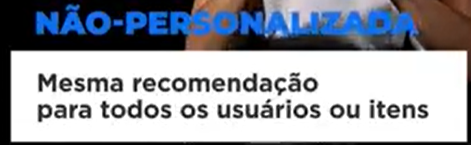

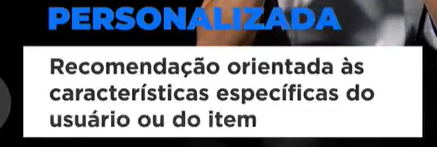

Exemplos de Recomendação Não Personalizadas:

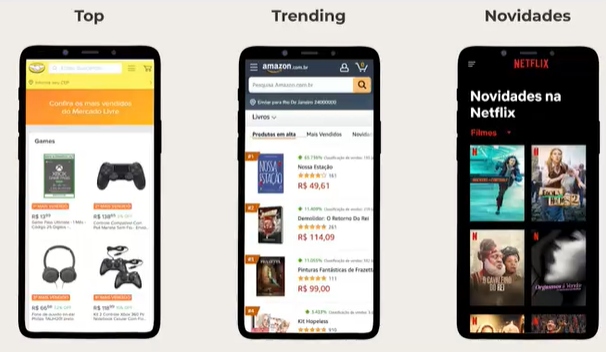

Mercado Livre mostra os top games mais vendidos.

Amazon itens em ascensão;

NetFlix os itens que acabaram de chegar no catálogo de itens

Por que fazemos uma Recomendação Não Personalizadas:

1- Algoritmos de menos complexidade;

2- Consegue oferecer pra usuários anônimos;

3- Serve quando o cliente é cold-start, ou seja, quando usuário é novo e demoramos pra recomendar itens de qualidade pra ele de acordo com as métricas de ;

4- Fallback para recomendação personalizada, todos os algoritmos estão sujeitos a falhar em algum momento, então podemos utilizar a Recomendação Não Personalizadas como uma segurança pra garantir que estaremos sempre entregando uma oferta personalizada para usuário, seja ela personalizada ou não personalizada;

5- Baseline para experiementos A/B de personalização. A ideia é que se está personalizando uma oferta pra um usuário o algoritmo personalizado deveria ser melhor do que um algoritmo não personalizado

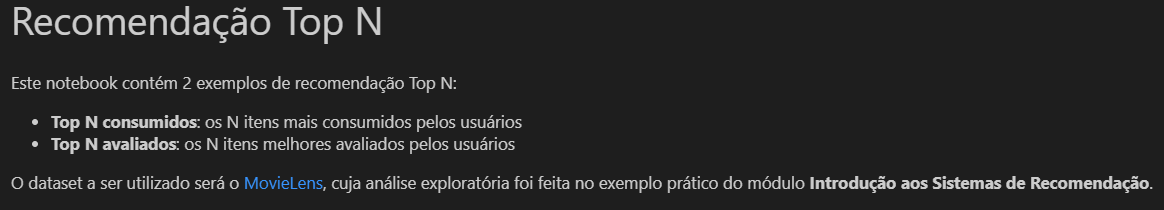

In [12]:
import os
import sys
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

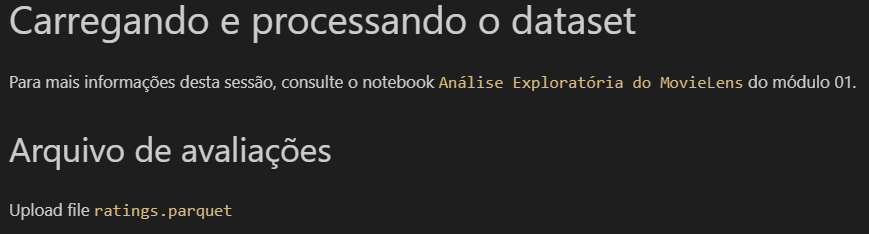

In [ ]:
%%time
_ = files.upload() # approx: 1min56s

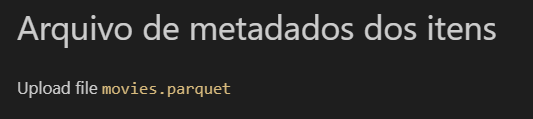

In [ ]:
%%time
_ = files.upload() # approx: 10s

In [ ]:
def convert_genres_to_list(genres:str, separator='|'):
    return genres.split(separator)

df_items = pd.read_parquet('movies.parquet')
df_items['genres'] = df_items['genres'].apply(convert_genres_to_list)
df_items.tail()

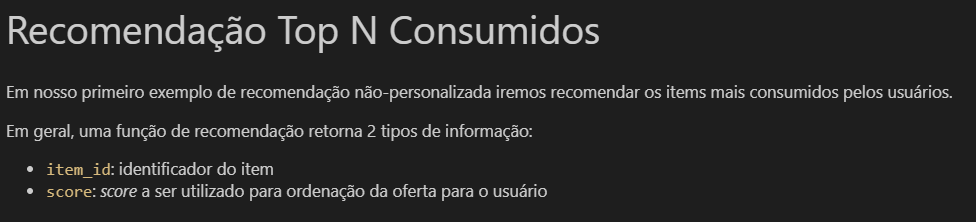

recommend_top_n_consumptions essa função vai receber dataframe de avaliações e o números de recomendações que vai ser feita pro usuário.

df_top_consumptions = recommend_top_n_consumptions(df_ratings, n=10) vai chamar a função passando como argumento o dataframe de avaliações e os 10 primeiros itens ordenados por score;

.groupby('item_id') agrupando por item;

.count()['user_id'] contabilizar quantos usuários avaliaram esse item

.reset_index() resetar o indice pra que a série vire um dataframe

.rename({'user_id': 'score'}, axis=1) recebe como parâmetro um dicionário com nome da coluna antiga e o valor é o novo nome da coluna. Quermos renomear a coluna (axis=1)

.sort_values(by='score', ascending=False) ordenar por score, recebe como parâmetros quais campos serão usamos para fazer essa recomendação de ordem decrescente.

In [ ]:
def recommend_top_n_consumptions(ratings:pd.DataFrame, n:int) -> pd.DataFrame:

    recommendations = (
        ratings
        .groupby('item_id')
        .count()['user_id']
        .reset_index()
        .rename({'user_id': 'score'}, axis=1)
        .sort_values(by='score', ascending=False)
    )

    return recommendations.head(n)

df_top_consumptions = recommend_top_n_consumptions(df_ratings, n=10)
df_top_consumptions

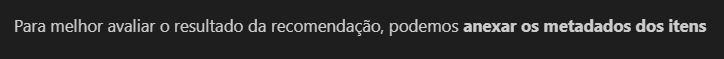

In [ ]:
df_top_consumptions.merge(df_items, on='item_id', how='inner')

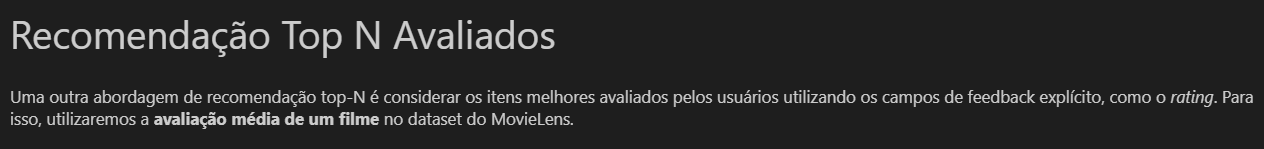

A função recommend_top_n_evaluations recebe como parâmetros um dataframe com as avaliações dos usuários pros itens, vai receber o n que é o número de recomendações que iremos fazer 

min_evaluations:int=None se apenas um cliente fizer uma avaliação, ela que será a determinante, pr evitar isso o min_evaluations:int=None vai dizer que quer o mínimo de avaliações sobre algum item pra poder recomendar pros usuários. Ela recebe o dataframe de ratings, número de recomendações, 

Precisamos calcular a média de avaliações de um item e ordenar esses itens por média de avaliação

.agg({'rating': 'mean', 'user_id': 'count'}) função de agregação utiliza um dicionário que recebe um dicionário em que a chave é a coluna e o valor média, 

if min_evaluations is not None:
        recommendations = recommendations.query('evaluations >= @min_evaluations') fazer um tipo de filtro no dataframe

recommendations.head(n) pegar os n primeiros itens do dataframe

In [ ]:
def recommend_top_n_evaluations(ratings:pd.DataFrame, n:int, min_evaluations:int=None) -> pd.DataFrame:
    recommendations = (
        ratings
        .groupby('item_id')
        .agg({'rating': 'mean', 'user_id': 'count'})
        .reset_index()
        .rename({'rating': 'score', 'user_id': 'evaluations'}, axis=1)
        .sort_values(by=['score', 'evaluations'], ascending=False)
    )

    if min_evaluations is not None:
        recommendations = recommendations.query('evaluations >= @min_evaluations')

    return recommendations.head(n)

recommend_top_n_evaluations(df_ratings, n=10, min_evaluations=None)

In [ ]:
df_top_evaluations = recommend_top_n_evaluations(df_ratings, n=10, min_evaluations=None)
df_top_evaluations.merge(df_items, on='item_id', how='inner')

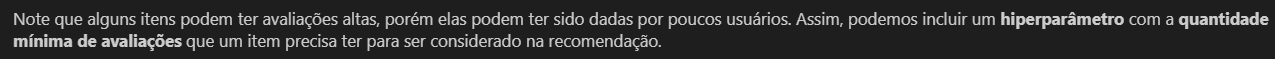

In [ ]:
df_top_evaluations = recommend_top_n_evaluations(df_ratings, n=10, min_evaluations=100)
df_top_evaluations.merge(df_items, on='item_id', how='inner')

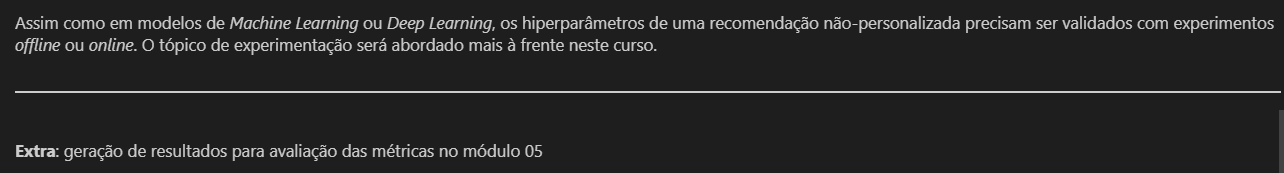

SELEÇÃO DE ACERVO E REGRAS DE NEGÓCIOS

VAmos decidir qual parte do acervo ou do catálogo vai ser recomendado. Essa parte do acervo vai entrar no modelo de recomendação, aonde vai ser feito todos os cálculos 

Uma vez que temos uma lista vamos ordenar e fazer essa apresentação pro usuário. Alguns filtros utilizados na seleção de acervos são:


Exemplos de filtros temporais:


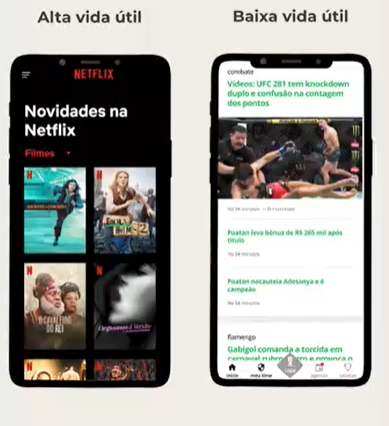

Recomendar os itens que foram lançados nas ultimas 24 horas, foram lançados no último mês?

No caso da globo, quando faz recomendação de matérias, matéria tem uma baixa vida útil, ou seja, se a matéria foi feita hoje ela daqui a 3 dias não vai mais servir. Então precisamos ter um tipo de filtragem temporal pra recomendar só as matérias mais recentes

Um segundo tipo de filtragem é a Filtragem de Categoria:

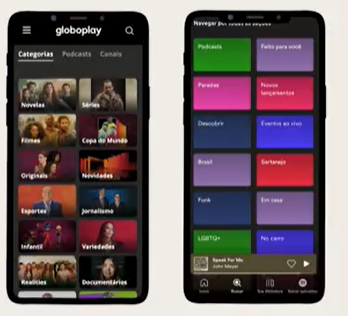

Um útltimo exemplo de filtragem é faixa etária

Outro são filtros de consumo:

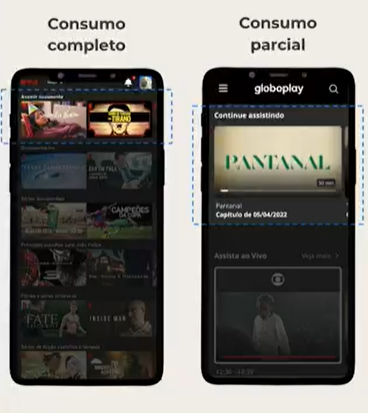

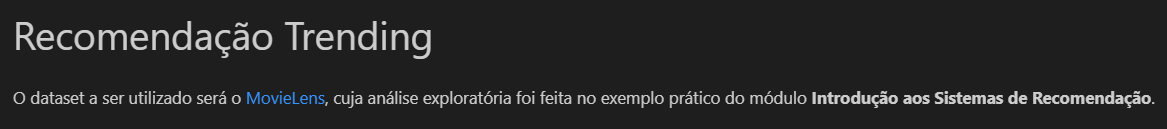

In [ ]:
import os
import re
import sys
import pandas as pd
from datetime import datetime
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

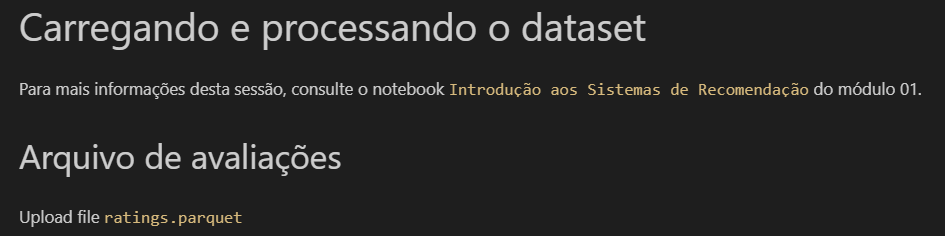

In [ ]:
%%time
_ = files.upload()

In [ ]:
def convert_timestamp_to_date(timestamp:int):
    return datetime.fromtimestamp(timestamp).date()    

df_ratings = pd.read_parquet('ratings.parquet')
df_ratings['date'] = df_ratings['timestamp'].apply(convert_timestamp_to_date)
df_ratings.tail() 

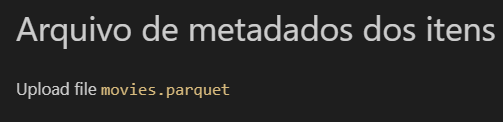

In [ ]:
def extract_year_from_title(title:str, regex='(\d{4})'):
    match = re.search(regex, title)
    return None if match is None else match.group()

def convert_genres_to_list(genres:str, separator='|'):
    return genres.split(separator)

df_items = pd.read_parquet('movies.parquet')
df_items['genres'] = df_items['genres'].apply(convert_genres_to_list)
df_items['year'] = df_items['title'].apply(extract_year_from_title)
df_items.tail()

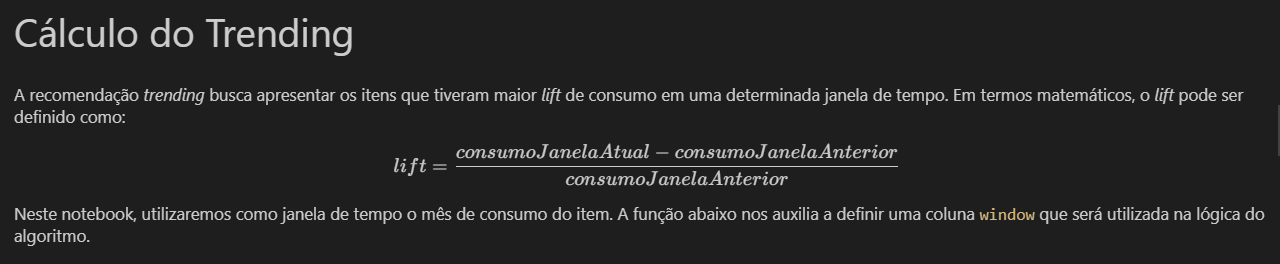

O Trending é baseado no Lift, o Lift é uma comparação entre uma métrica de uma janela atual com uma janela anterior. Precisamos definir o que é a janela que nada mais é do o período de tempo em que a gente ta considerando pra contabilizar se teve um aumento ou diminuição do consumo. 

Vamos utilizar como janela o ano e o mês de avaliação dos usuários

In [ ]:
def extract_year_month(date):
    return '{:04d}-{:02d}'.format(date.year, date.month)
    
df_ratings['window'] = df_ratings['date'].apply(extract_year_month)
df_ratings.tail()

Precisamos quanto de consumo teve pra cada item pra poder comparar na janela atual com a anterior se houve aumento ou diminuição de consumo

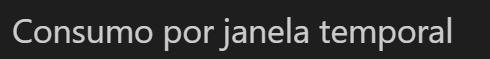

In [ ]:
df_window_consumptions = (
    df_ratings
    .groupby(['item_id', 'window'])
    .agg({'user_id': 'count'})
    .reset_index()
    .rename({'user_id': 'count'}, axis=1)
    .sort_values(by=['item_id', 'window'])
)
df_window_consumptions

  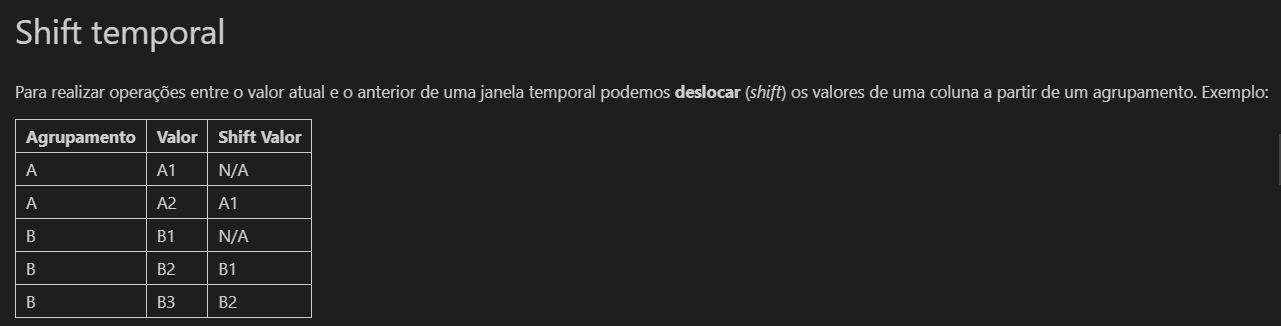

.shift(1) indica o número de shift que vai ser dado entre as linhas

In [ ]:
df_window_consumptions.sort_values(by=['item_id', 'window'], inplace=True)

df_window_consumptions['count_previous'] = (
    df_window_consumptions
    .groupby(['item_id'])['count']
    .shift(1)
)
df_window_consumptions

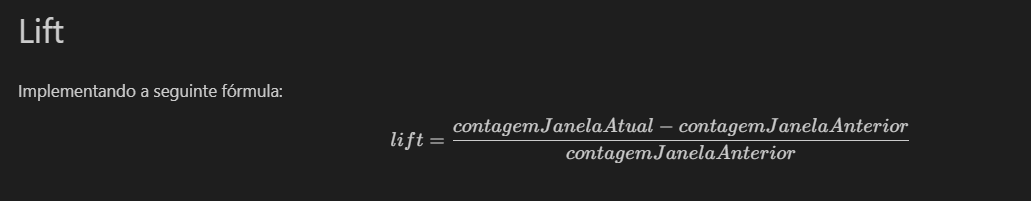

In [ ]:
df_window_consumptions['lift'] = (df_window_consumptions['count'] - df_window_consumptions['count_previous'])/df_window_consumptions['count_previous']
df_window_consumptions

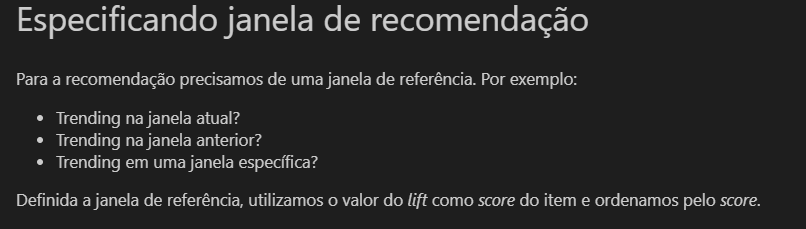

In [ ]:
prediction_window = '2003-01'
(
    df_window_consumptions
    .query('window == @prediction_window')
    .rename({'lift': 'score'}, axis=1)
    .sort_values(by='score', ascending=False)
)

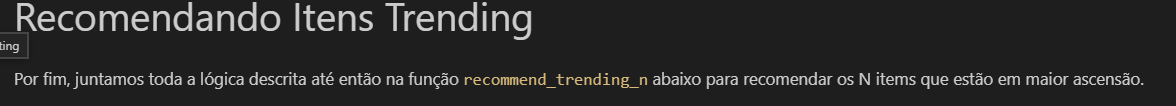

In [ ]:
def recommend_trending_n(ratings:pd.DataFrame, n:int, prediction_window:str=None, min_evaluations:int=None) -> pd.DataFrame:

    prediction_window = max(ratings['window']) if prediction_window is None else prediction_window

    ratings = ratings[['item_id', 'window', 'user_id']]
    # Calculo de janela
    df_window_consumptions = (
        ratings
        .groupby(['item_id', 'window'])['user_id']
        .count()
        .reset_index()
        .rename({'user_id': 'count'}, axis=1)
        .sort_values(by=['item_id', 'window'])
    )

    # Shift temporal
    df_window_consumptions['count_previous'] = (
        df_window_consumptions
        .groupby(['item_id'])['count']
        .shift(1)
    )

    # Calculo do lift
    df_window_consumptions['lift'] = (df_window_consumptions['count'] - df_window_consumptions['count_previous'])/df_window_consumptions['count_previous']

    # Selecao de janela
    recommendations = (
      df_window_consumptions
      .query('window == @prediction_window')
      .rename({'lift': 'score'}, axis=1)
      .sort_values(by='score', ascending=False)
    )

    if min_evaluations is not None:
        recommendations = recommendations.query('count_previous >= @min_evaluations')

    return recommendations.head(n)

df_trending = recommend_trending_n(df_ratings, n=10, prediction_window='2002-12')
df_trending.merge(df_items, on='item_id', how='inner')

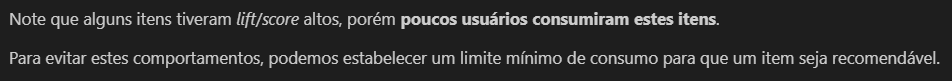

In [ ]:
prediction_window = '2002-12'
min_evaluations = 2
n = 10

df_trending = recommend_trending_n(
    df_ratings, 
    n=n,
    prediction_window=prediction_window,
    min_evaluations=min_evaluations
)
df_trending.merge(df_items, on='item_id', how='inner')

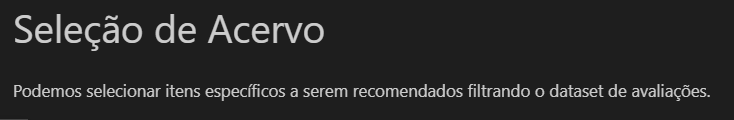

In [ ]:
genre = "Children's"
item_ids = df_items[df_items['genres'].apply(lambda x: genre in x)]['item_id']
df_ratings_filtered = df_ratings[df_ratings['item_id'].isin(item_ids)]
df_ratings_filtered.tail()

In [ ]:
df_trending = recommend_trending_n(df_ratings_filtered, n=10, prediction_window='2002-12', min_evaluations=2)
df_trending.merge(df_items, on='item_id', how='inner')